# <a id='toc1_'></a>[Tarea realizada por Carlos Sánchez Polo y Jesús Martínez Leal](#toc0_)
Última edición: 29/02/2024

**Table of contents**<a id='toc0_'></a>    
 
- [Box-counting in three dimensional numpy arrays.](#toc2_)    
    - [Usage](#toc2_1_1_)    
  - [Fractal Dimension of the cerebral cortex](#toc2_2_)    
    - [- Carga la imagen Nifti usando la librería nibabel.](#toc2_2_1_)    
    - [- Representa la imagen utilizando un deslizador para ver todos los cortes de manera interactiva.](#toc2_2_2_)    
    - [- Calcula la dimensión fractal](#toc2_2_3_)    
    - [- ¿Qué significa el hiperparámetro n_samples y qué efecto tiene?](#toc2_2_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

Open this repository in binder:[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ChatzigeorgiouGroup/FractalDimension/master)


# <a id='toc2_'></a>[Box-counting in three dimensional numpy arrays.](#toc0_)

Description from [wikipedia](https://en.wikipedia.org/wiki/Fractal_dimension)
>In mathematics, more specifically in fractal geometry, a fractal dimension is a ratio providing a statistical index of complexity comparing how detail in a pattern (strictly speaking, a fractal pattern) changes with the scale at which it is measured. It has also been characterized as a measure of the space-filling capacity of a pattern that tells how a fractal scales differently from the space it is embedded in; a fractal dimension does not have to be an integer.

Here we offer a function that calculates the fractal dimension of an object embedded in three dimensional space using the boxcounting method, also known as the [Minkowski-Bouligand](https://en.wikipedia.org/wiki/Minkowski%E2%80%93Bouligand_dimension) dimension.

### <a id='toc2_1_1_'></a>[Usage](#toc0_)
Simple example, measuring a box in 3D space.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#test data
box = np.zeros(shape = (100,100,100))
box[20:80,20:80,20:80] = 1

In [2]:
def fractal_dimension(array, max_box_size=None, min_box_size=1, n_samples=10, n_offsets=0, plot=False):
    """Calculates the fractal dimension of a 3D numpy array.
    
    Args:
        array (np.ndarray): The array to calculate the fractal dimension of.
        max_box_size (int): The largest box size, given as the power of 2 so that
                            2**max_box_size gives the sidelength of the largest box.                     
        min_box_size (int): The smallest box size, given as the power of 2 so that
                            2**min_box_size gives the sidelength of the smallest box.
                            Default value 1.
        n_samples (int): number of scales to measure over.
        n_offsets (int): number of offsets to search over to find the smallest set N(s) to
                         cover all voxels>0.
        plot (bool): Whether to plot the results. Default is False.
        
    Returns:
        tuple: A tuple containing the fractal dimension and the coefficient of determination (R-squared).
    """
    # Determine the scales to measure on
    if max_box_size is None:
        # Default max size is the largest power of 2 that fits in the smallest dimension of the array:
        max_box_size = int(np.floor(np.log2(np.min(array.shape))))
    scales = np.floor(np.logspace(max_box_size, min_box_size, num=n_samples, base=2)) # n_samples determina el número de escalas que se generarán entre max_box_size y min_box_size
    scales = np.unique(scales)  # Remove duplicates that could occur as a result of the floor
    
    # Get the locations of all non-zero pixels
    locs = np.where(array > 0)
    voxels = np.array([(x, y, z) for x, y, z in zip(*locs)])
    
    # Count the minimum amount of boxes touched
    Ns = []
    # Loop over all scales
    for scale in scales:
        touched = []
        if n_offsets == 0:
            offsets = [0]
        else:
            offsets = np.linspace(0, scale, n_offsets)
        # Search over all offsets
        for offset in offsets:
            bin_edges = [np.arange(0, i, scale) for i in array.shape]
            bin_edges = [np.hstack([0 - offset, x + offset]) for x in bin_edges]
            H1, e = np.histogramdd(voxels, bins=bin_edges)
            touched.append(np.sum(H1 > 0))
        Ns.append(touched)
    Ns = np.array(Ns)
    
    # From all sets N found, keep the smallest one at each scale
    Ns = Ns.min(axis=1)
    
    # Only keep scales at which Ns changed
    scales = np.array([np.min(scales[Ns == x]) for x in np.unique(Ns)])
    Ns = np.unique(Ns)
    Ns = Ns[Ns > 0]
    scales = scales[:len(Ns)]
    # Perform fit
    coeffs = np.polyfit(np.log(1 / scales), np.log(Ns), 1)
    
    # Calculate R-squared
    fitted_y_vals = np.polyval(coeffs, np.log(1 / scales))
    ss_res = np.sum((np.log(Ns) - fitted_y_vals) ** 2)
    ss_tot = np.sum((np.log(Ns) - np.mean(np.log(Ns))) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Make plot
    if plot:
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(np.log(1 / scales), np.log(np.unique(Ns)), c="teal", label="Measured ratios")
        ax.set_ylabel("$\log N(\epsilon)$")
        ax.set_xlabel("$\log 1/ \epsilon$")
        ax.plot(np.log(1 / scales), fitted_y_vals, "k--", label=f"Fit: {np.round(coeffs[0], 3)}X+{coeffs[1]}")
        ax.legend()
    
    return coeffs[0], r_squared

For a more complete overview of the function and its parameters, have a look at the notebook detailing the development of the function in binder.

## <a id='toc2_2_'></a>[Fractal Dimension of the cerebral cortex](#toc0_)


In [3]:
import os
import tifffile
from skimage import filters
from skimage import exposure
import ipywidgets as widgets
import nibabel as nib
from ipywidgets import interact, interact_manual

### <a id='toc2_2_1_'></a>[- Carga la imagen Nifti usando la librería nibabel.](#toc0_)

In [4]:
# Ruta al archivo de imagen NIfTI (.nii)
ruta_imagen = 'Pitt_0050028_cortex_mask.nii.gz'

# Cargar la imagen NIfTI
imagen_nifti = nib.load(ruta_imagen)

# Obtener los datos de la imagen
datos_imagen = imagen_nifti.get_fdata()

# Obtener información sobre la imagen
informacion_imagen = imagen_nifti.header

# Por ejemplo, puedes imprimir la forma de los datos de la imagen
print("Forma de los datos de la imagen:", datos_imagen.shape)

# También puedes imprimir información adicional sobre la imagen
print("Información de la imagen:", informacion_imagen)

Forma de los datos de la imagen: (256, 256, 256)
Información de la imagen: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FreeSurfer Aug  4 2022'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.70710677
quatern_d       : -0.70710677
qof

### <a id='toc2_2_2_'></a>[- Representa la imagen utilizando un deslizador para ver todos los cortes de manera interactiva.](#toc0_)

In [5]:
exponent_data = np.log(np.min(datos_imagen.shape)) / np.log(2) #express the smallest dimension of our array as an exponent of 2
largest_box_size_exponent = int(np.floor(exponent_data)) #find the largest power of 2 that fits in our array
print(f"largest_box_size = {2**largest_box_size_exponent}")

largest_exponent = int(np.floor(np.log2(np.min(box.shape))))
print(f"exponent = {largest_exponent}, box size = {2**largest_exponent}")

scales = [2**x for x in range(largest_exponent, 1, -1)]

print(scales)

largest_box_size = 256
exponent = 6, box size = 64
[64, 32, 16, 8, 4]


In [6]:
@interact
def plot_scale(scale = scales, plane = (0, datos_imagen.shape[0]-1)):
    
    #create bin edges from 0 to the max size of the box in each dimension
    bin_edges = [np.arange(0,i,scale) for i in datos_imagen.shape]

    fig, ax = plt.subplots(figsize = (5,5))
    ax.set_xlim(0,datos_imagen.shape[0])
    ax.set_ylim(0,datos_imagen.shape[1])
    
    
    ax.axis("equal")
    ax.set_title("Box in white, space in black")
    ax.imshow(datos_imagen[plane], cmap = "gray")
    ax.vlines(bin_edges[0], 0, datos_imagen.shape[0], color="r") #x-values
    ax.hlines(bin_edges[1], 0, datos_imagen.shape[1], color ="r")#y-values

interactive(children=(Dropdown(description='scale', options=(64, 32, 16, 8, 4), value=64), IntSlider(value=127…

### <a id='toc2_2_3_'></a>[- Calcula la dimensión fractal](#toc0_)

Para calcularla representamos el logaritmo del mínimo número de cajas de tamaño $\epsilon$ para cubrir el objeto (`N`) frente al logaritmo de 1/$\epsilon$. De la pendiente se obtiene.

Fractal Dimension of the box: 2.574700780195339
El R^2 es: 0.9945132148404722


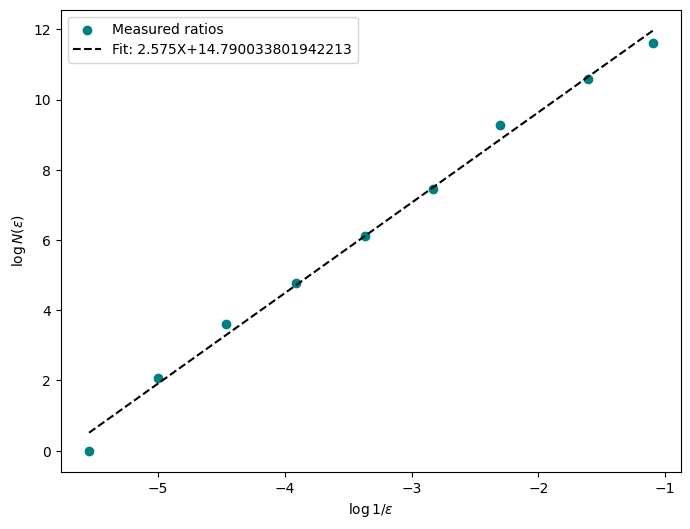

In [7]:
fd, r2 = fractal_dimension(datos_imagen, n_offsets=10, plot = True)
print(f"Fractal Dimension of the box: {fd}")
print(f"El R^2 es: {r2}")
plt.show()

### <a id='toc2_2_4_'></a>[- ¿Qué significa el hiperparámetro n_samples y qué efecto tiene?](#toc0_)

El hiperparámetro `n_samples` determina el número de escalas a medir durante el cálculo de la dimensión fractal. Cada escala representa un tamaño de caja diferente utilizado para analizar la estructura del objeto tridimensional.

A medida que aumenta `n_samples`, el algoritmo calculará la dimensión fractal en una mayor cantidad de escalas, lo que puede proporcionar una mejor comprensión de cómo la estructura del objeto varía a diferentes niveles de detalle. Sin embargo, esto también puede aumentar el tiempo de cálculo, ya que se necesitarán más iteraciones para realizar las mediciones en más escalas.

- Varíamos este parámetro entre 5 y 50 y representa en un gráfico la dimensión fractal vs n_samples. ¿Qué valor escogerías?

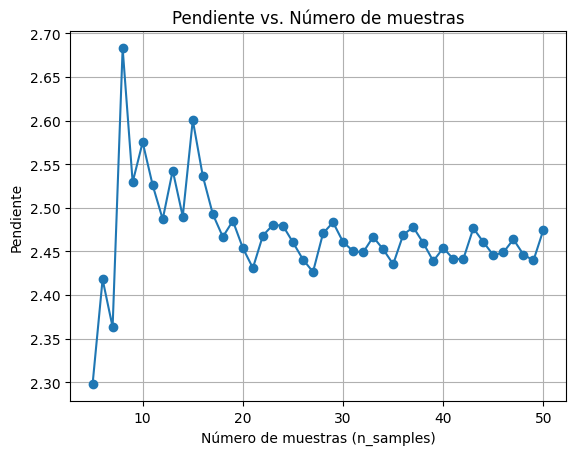

In [8]:
# Crear un diccionario para almacenar las pendientes y los valores de R-cuadrado
resultados = {}

# Bucle para variar n_samples de 5 a 50 de 1 en 1

for n in range(5, 51, 1):
    # Calcular la dimensión fractal con el número de muestras actual
    pendiente, rsq = fractal_dimension(datos_imagen, n_samples=n)
    
    # Almacenar los resultados en el diccionario
    resultados[n] = {'pendiente': pendiente, 'r_cuadrado': rsq}

# Crear un plot de los valores de la pendiente frente a n_samples
plt.plot(resultados.keys(), [resultado['pendiente'] for resultado in resultados.values()], marker='o')
plt.xlabel('Número de muestras (n_samples)')
plt.ylabel('Pendiente')
plt.title('Pendiente vs. Número de muestras')
plt.grid(True)
plt.show()


Para seleccionar el valor de n_samples es razonable considerar el que hace que la regresión lineal (cálculo de dimensión fractal) sea mayor.

In [9]:
# Encontrar el valor de n_samples que maximiza el valor de R-cuadrado
n_samples_optimo = max(resultados, key=lambda x: resultados[x]['r_cuadrado'])

# Obtener la información deseada del diccionario utilizando el valor de n_samples óptimo
informacion_optima = resultados[n_samples_optimo]

# Imprimir la información deseada
print(f"Para n_samples = {n_samples_optimo} obtenemos el valor de R-cuadrado mayor {informacion_optima['r_cuadrado']}. La pendiente obtenida es para este {informacion_optima['pendiente']}")

Para n_samples = 6 obtenemos el valor de R-cuadrado mayor 0.9999607279818195. La pendiente obtenida es para este 2.4181380931694014


In [10]:
print(resultados.values())

dict_values([{'pendiente': 2.2978743149383125, 'r_cuadrado': 0.9974098663955714}, {'pendiente': 2.4181380931694014, 'r_cuadrado': 0.9999607279818195}, {'pendiente': 2.3633622975365434, 'r_cuadrado': 0.9961316878484763}, {'pendiente': 2.6827586485202515, 'r_cuadrado': 0.9924136319666716}, {'pendiente': 2.5293124112010594, 'r_cuadrado': 0.984956975819881}, {'pendiente': 2.5751365548097396, 'r_cuadrado': 0.9945310807515593}, {'pendiente': 2.525844630809076, 'r_cuadrado': 0.9958591583280866}, {'pendiente': 2.486898767310741, 'r_cuadrado': 0.9942462302504727}, {'pendiente': 2.5427455241329264, 'r_cuadrado': 0.9886579705697467}, {'pendiente': 2.4900597085700595, 'r_cuadrado': 0.9863763080688249}, {'pendiente': 2.600466437208317, 'r_cuadrado': 0.9926372252313007}, {'pendiente': 2.5364573778662396, 'r_cuadrado': 0.9958581633226921}, {'pendiente': 2.492734529059242, 'r_cuadrado': 0.9953561388883759}, {'pendiente': 2.466734888390861, 'r_cuadrado': 0.9940653045437162}, {'pendiente': 2.48504769909

También podría pensarse en utilizar un valor para `n_samples` que sea lo menor posible (disminuir tiempo de cálculo) pero que tenga un valor que se repita con cierta frecuencia para distintos valores. En este caso, podría otorgarse un n_samples de en torno a 20 si se mira de esta manera.